# Semantic Symptom Encoder - Unified Training & Comparison

This notebook consolidates the Semantic Symptom Encoder training, testing, and model comparison:

## Contents
1. **Part 1: Embedding Generation** - Compute embeddings for symptom vocabulary
2. **Part 2: Testing** - Validate semantic understanding on various symptom phrases
3. **Part 3: Model Comparison** - Compare different sentence transformer models

**Key Features:**
- Zero ML training required - uses pre-trained sentence embeddings
- Semantic understanding - "can't breathe" ≈ "shortness of breath"
- Sentence-level encoding - prevents symptom dilution in long text
- Max-pooling - for each symptom, takes best match across sentences

**Architecture:**
```
Free-text input → Sentence Transformer → Cosine Similarity → Top-K Symptoms
                  (multi-qa-mpnet)       (vs 480 symptoms)
```

In [1]:
!git clone https://github.com/endvidous/Multimodal_Diagnosis
%cd Multimodal_Diagnosis


Cloning into 'Multimodal_Diagnosis'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 76 (delta 10), reused 75 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 8.82 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/Multimodal_Diagnosis


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json, joblib, warnings, sys, os, time
from tqdm import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

project_root = Path(os.getcwd()).parent.parent
sys.path.insert(0, str(project_root))

from sklearn.metrics import accuracy_score, top_k_accuracy_score

print(f"Project root: {project_root}")

from utils.paths import get_data_root

data_root = get_data_root()
print(f"Data root: {data_root}")

Project root: /
Data root: /content/drive/MyDrive/Multi_Modal_Data


---
# Part 1: Training (Embedding Generation)

The semantic encoder doesn't require traditional ML training. Instead, it:
1. Loads the symptom vocabulary (480 canonical symptoms)
2. Computes embeddings using pre-trained sentence transformer
3. Caches embeddings for fast inference

## 1.1 Check Current Symptom Vocabulary

In [5]:
# Load symptom vocabulary
vocab_path = data_root / "data" / "symptom_vocabulary.json"
with open(vocab_path) as f:
    symptoms = json.load(f)

print(f"Symptom vocabulary: {len(symptoms)} symptoms")
print(f"\nFirst 10 symptoms:")
for i, s in enumerate(symptoms[:10]):
    print(f"  {i+1}. {s}")

print(f"\nLast 10 symptoms:")
for i, s in enumerate(symptoms[-10:]):
    print(f"  {len(symptoms)-9+i}. {s}")

Symptom vocabulary: 480 symptoms

First 10 symptoms:
  1. abdominal distention
  2. abdominal pain
  3. abdominal swelling
  4. abnormal appearing skin
  5. abnormal appearing tongue
  6. abnormal breathing sounds
  7. abnormal heart rhythm
  8. abnormal involuntary movements
  9. abnormal movement of eyelid
  10. abnormal size or shape of ear

Last 10 symptoms:
  471. weight gain
  472. weight loss
  473. wheezing
  474. white discharge from eye
  475. wrinkles on skin
  476. wrist lump or mass
  477. wrist pain
  478. wrist stiffness or tightness
  479. wrist swelling
  480. wrist weakness


## 1.2 Check Consistency with Model Features

The symptom vocabulary should match the features used to train the disease classifiers.

In [6]:
# Load model feature columns
model_cols_path = project_root / "models" / "checkpoints" / "symptom_columns.json"
if model_cols_path.exists():
    with open(model_cols_path) as f:
        model_cols = json.load(f)

    print(f"Model uses: {len(model_cols)} symptom features")
    print(f"Vocabulary: {len(symptoms)} symptoms")

    missing = [s for s in model_cols if s not in symptoms]
    extra = [s for s in symptoms if s not in model_cols]

    if missing:
        print(f"\n⚠️ {len(missing)} symptoms in model but NOT in vocabulary:")
        print(f"   {missing[:5]}...")
    if extra:
        print(f"\n⚠️ {len(extra)} symptoms in vocabulary but NOT in model:")
        print(f"   {extra[:5]}...")
    if not missing and not extra:
        print("\n✓ Vocabulary matches model features exactly!")
else:
    print("No model checkpoints found")

No model checkpoints found


## 1.3 Update Vocabulary (if needed)

Run this cell to sync vocabulary with model features.

In [7]:
# Uncomment to update vocabulary to match model features
# ONLY run this if there are missing symptoms

UPDATE_VOCABULARY = False  # Set to True to update

if UPDATE_VOCABULARY and model_cols_path.exists():
    # Merge vocabularies
    updated = sorted(set(symptoms + model_cols))

    # Backup original
    backup_path = project_root / "data" / "symptom_vocabulary_backup.json"
    with open(backup_path, 'w') as f:
        json.dump(symptoms, f, indent=2)
    print(f"Backed up original to {backup_path.name}")

    # Save updated
    with open(vocab_path, 'w') as f:
        json.dump(updated, f, indent=2)

    print(f"Updated vocabulary: {len(symptoms)} → {len(updated)} symptoms")
    symptoms = updated
else:
    print("Vocabulary update skipped (set UPDATE_VOCABULARY = True to update)")

Vocabulary update skipped (set UPDATE_VOCABULARY = True to update)


## 1.4 Generate Embeddings

This is the "training" step - computing embeddings for all symptoms.
Embeddings are cached to `data/embeddings/semantic_symptom_embeddings.npy`.

In [8]:
from models.architectures.semantic_symptom_encoder import SemanticSymptomEncoder

# Check if embeddings exist
MODEL_NAME = "all-MiniLM-L12-v2"
embeddings_path = data_root / "data" / "embeddings" / f"semantic_symptom_embeddings_{MODEL_NAME}.npy"
if embeddings_path.exists():
    existing = np.load(embeddings_path)
    print(f"Existing embeddings: {existing.shape}")
    if existing.shape[0] != len(symptoms):
        print(f"⚠️ Mismatch! Vocabulary has {len(symptoms)} symptoms but embeddings have {existing.shape[0]}")
        print("   Embeddings will be regenerated on encoder init.")
else:
    print("No cached embeddings found - will compute on init.")

Existing embeddings: (480, 384)


In [11]:
# Initialize encoder (this computes embeddings if needed)
encoder = SemanticSymptomEncoder(
    model_name=MODEL_NAME,
    device = "cuda"
)

print(f"\n✓ Encoder ready!")
print(f"  Symptoms: {len(encoder.symptoms)}")
print(f"  Embeddings: {encoder.symptom_embeddings.shape}")
print(f"  Model: {encoder.model_name}")

[Encoder] Loading model: all-MiniLM-L12-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 480 symptoms

✓ Encoder ready!
  Symptoms: 480
  Embeddings: (480, 384)
  Model: all-MiniLM-L12-v2


## 1.5 Force Regenerate Embeddings (Optional)

Use this if you've updated the vocabulary or enrichment function.

In [12]:
# Uncomment to force regeneration
# encoder.regenerate_embeddings()
print("To force regeneration, uncomment: encoder.regenerate_embeddings()")

[Encoder] Computing symptom embeddings (one-time)


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

To force regeneration, uncomment: encoder.regenerate_embeddings()


---
# Part 2: Testing

Validate that the semantic encoder correctly understands symptom phrases.

## 2.1 Basic Symptom Matching

In [15]:
simple_tests = [
    "my head is killing me",
    "headache",
    "I have a terrible headache",
    "pain in my head",
    "migraine",
    "head hurts so bad"
]

print("Testing variations of 'headache':\n")

for text in simple_tests:
    result = encoder.encode_symptoms(text)
    vec = result["symptom_vector"]

    # top-5 evidence symptoms
    top_indices = np.argsort(vec)[-5:][::-1]

    print(f"  '{text}'")
    for i in top_indices:
        print(f"    → {encoder.idx_to_symptom[i]} ({vec[i]:.3f})")
    print()

Testing variations of 'headache':

  'my head is killing me'
    → headache (0.004)
    → focal weakness (0.000)
    → foot or toe cramps or spasms (0.000)
    → foot or toe lump or mass (0.000)
    → foot or toe pain (0.000)

  'headache'
    → headache (0.900)
    → headaches (0.090)
    → ache all over (0.019)
    → pain (0.018)
    → frontal headache (0.017)

  'I have a terrible headache'
    → headache (0.900)
    → headaches (0.040)
    → poor circulation (0.007)
    → ache all over (0.007)
    → mass on ear (0.002)

  'pain in my head'
    → pain (0.900)
    → confusion (0.044)
    → blindness (0.028)
    → headache (0.027)
    → mass on ear (0.020)

  'migraine'
    → headache (0.049)
    → headaches (0.040)
    → pain (0.010)
    → ache all over (0.008)
    → feeling ill (0.004)

  'head hurts so bad'
    → headache (0.028)
    → headaches (0.009)
    → lightheadedness (0.007)
    → skin on head or neck looks infected (0.007)
    → pain (0.007)



## 2.2 Sentence-Level vs Whole-Text Encoding

Sentence-level encoding prevents symptom dilution in long paragraphs.

In [16]:
def encode_whole_text(encoder, text):
    emb = encoder.model.encode(
        text,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    pooled = emb @ encoder.symptom_embeddings.T
    evidence = np.clip(pooled - 0.25, 0, 1) ** 1.5
    return evidence


In [17]:
long_text = """
I've been feeling really unwell for the past few days. I have a terrible headache
that won't go away, and I feel nauseous all the time. Yesterday I started throwing up
and now I have diarrhea too. My whole body aches and I'm running a fever.
I also feel really tired and weak, can barely get out of bed.
"""

# Sentence-level (normal encoder)
sent_vec = encoder.encode_symptoms(long_text)["symptom_vector"]

# Whole-text (baseline)
whole_vec = encode_whole_text(encoder, long_text)

print("COMPARISON: Sentence-level vs Whole-text")
print("=" * 60)

headache_idx = encoder.symptom_to_idx.get("headache", None)

if headache_idx is not None:
    print(f"\nHeadache evidence:")
    print(f"  🟢 Sentence-level: {sent_vec[headache_idx]:.3f}")
    print(f"  🔴 Whole-text:    {whole_vec[headache_idx]:.3f}")

print("\nTop symptoms (sentence-level):")
for i in np.argsort(sent_vec)[-8:][::-1]:
    print(f"  {encoder.idx_to_symptom[i]}: {sent_vec[i]:.3f}")

print("\nTop symptoms (whole-text):")
for i in np.argsort(whole_vec)[-8:][::-1]:
    print(f"  {encoder.idx_to_symptom[i]}: {whole_vec[i]:.3f}")

better = "BETTER" if sent_vec[headache_idx] > whole_vec[headache_idx] else "worse"
print(f"\n→ Sentence-level is {better} at preserving headache evidence")

COMPARISON: Sentence-level vs Whole-text

Headache evidence:
  🟢 Sentence-level: 0.900
  🔴 Whole-text:    0.021

Top symptoms (sentence-level):
  diarrhea: 0.900
  fever: 0.900
  headache: 0.900
  nausea and vomitting: 0.111
  vomitting: 0.088
  feeling ill: 0.084
  nausea: 0.080
  high fever: 0.071

Top symptoms (whole-text):
  diarrhea: 0.115
  nausea and vomitting: 0.114
  nausea: 0.085
  feeling ill: 0.077
  vomiting: 0.077
  vomitting: 0.076
  upset stomach: 0.070
  high fever: 0.058

→ Sentence-level is BETTER at preserving headache evidence


## 2.3 Comprehensive Test Suite

In [19]:
test_cases = { "Chest pain": "sharp pain in my chest, feels like pressure", "Breathing": "I can't catch my breath, feels like I'm suffocating", "Cold symptoms": "runny nose, sore throat, and sneezing a lot", "Stomach": "my stomach hurts after eating, lots of bloating", "Anxiety": "feeling extremely anxious, can't calm down, heart racing", "UTI": "burning when I pee and need to go constantly", "Fatigue": "exhausted all the time, no energy to do anything", "Fever": "running a high temperature, chills and sweating", }

print("Comprehensive Test Results:")
print("=" * 60)

TOP_K = 5  # how many symptoms to inspect

for category, text in test_cases.items():
    result = encoder.encode_symptoms(text)
    vec = result["symptom_vector"]

    top_indices = np.argsort(vec)[-TOP_K:][::-1]

    print(f"\n📋 {category}")
    print(f"   Input: \"{text}\"")
    print("   Top symptom evidence:")
    for i in top_indices:
        print(f"      • {encoder.idx_to_symptom[i]}: {vec[i]:.3f}")

Comprehensive Test Results:

📋 Chest pain
   Input: "sharp pain in my chest, feels like pressure"
   Top symptom evidence:
      • pain: 0.900
      • chest pain: 0.031
      • sharp chest pain: 0.023
      • chest tightness: 0.014
      • gas: 0.007

📋 Breathing
   Input: "I can't catch my breath, feels like I'm suffocating"
   Top symptom evidence:
      • flushing: 0.029
      • difficulty breathing: 0.023
      • lethargy: 0.012
      • breathing problems: 0.009
      • breathing fast: 0.009

📋 Cold symptoms
   Input: "runny nose, sore throat, and sneezing a lot"
   Top symptom evidence:
      • sore throat: 0.900
      • sneezing: 0.900
      • cough: 0.030
      • nosebleed: 0.022
      • sore in nose: 0.020

📋 Stomach
   Input: "my stomach hurts after eating, lots of bloating"
   Top symptom evidence:
      • bloating: 0.900
      • stomach bloating: 0.025
      • difficulty eating: 0.016
      • excessive appetite: 0.004
      • vomitting: 0.003

📋 Anxiety
   Input: "feeling ex

## 2.4 Edge Cases & Robustness

In [20]:
edge_cases = [
    ("", "Empty string"),
    ("headach", "Typo: headach"),
    ("stomache ake", "Typo: stomache ake"),
    ("my tummy hurts so bad", "Informal: tummy hurts"),
    ("experiencing dyspnea and tachycardia", "Medical terms"),
    ("I don't have a headache", "Negation (known limitation)"),
]

print("Edge Case Testing:")
print("=" * 60)

for text, description in edge_cases:
    result = encoder.encode_symptoms(text)
    vec = result["symptom_vector"]

    top_indices = np.argsort(vec)[-TOP_K:][::-1]

    print(f"\n📋 {category}")
    print(f"   Input: \"{text}\"")
    print("   Top symptom evidence:")
    for i in top_indices:
        print(f"      • {encoder.idx_to_symptom[i]}: {vec[i]:.3f}")

Edge Case Testing:

📋 Fever
   Input: ""
   Top symptom evidence:
      • ankle pain: 0.000
      • ankle stiffness or tightness: 0.000
      • ankle swelling: 0.000
      • ankle weakness: 0.000
      • antisocial behavior: 0.000

📋 Fever
   Input: "headach"
   Top symptom evidence:
      • ankle pain: 0.000
      • ankle stiffness or tightness: 0.000
      • ankle swelling: 0.000
      • ankle weakness: 0.000
      • antisocial behavior: 0.000

📋 Fever
   Input: "stomache ake"
   Top symptom evidence:
      • ankle pain: 0.000
      • ankle stiffness or tightness: 0.000
      • ankle swelling: 0.000
      • ankle weakness: 0.000
      • antisocial behavior: 0.000

📋 Fever
   Input: "my tummy hurts so bad"
   Top symptom evidence:
      • stomach pain: 0.011
      • coryza: 0.010
      • swollen abdomen: 0.001
      • ache all over: 0.001
      • upset stomach: 0.000

📋 Fever
   Input: "experiencing dyspnea and tachycardia"
   Top symptom evidence:
      • decreased heart rate: 0.066


## 2.5 Threshold Tuning

Adjust threshold to balance precision vs recall:
- Lower (0.4-0.5): More symptoms, may include false positives
- Higher (0.6+): Fewer symptoms, higher precision

In [22]:
test_text = "I have chest pain, difficulty breathing, and headache"
print(f"Testing: \"{test_text}\"\n")

result = encoder.encode_symptoms(test_text)
vec = result["symptom_vector"]

# show top evidence symptoms
top_indices = np.argsort(vec)[-10:][::-1]

print("Top symptom evidence:")
for i in top_indices:
    print(f"  • {encoder.idx_to_symptom[i]}: {vec[i]:.3f}")


Testing: "I have chest pain, difficulty breathing, and headache"

Top symptom evidence:
  • headache: 0.900
  • difficulty breathing: 0.900
  • chest pain: 0.900
  • pain: 0.900
  • breathing problems: 0.094
  • hurts to breath: 0.045
  • breathing fast: 0.044
  • decreased heart rate: 0.035
  • cough: 0.030
  • irregular heartbeat: 0.030


## 2.6 Integration Test (Binary Vector for Classifier)

In [23]:
patient_description = """
I've been having severe headaches for the past week, especially in the morning.
Also experiencing nausea, and the light bothers my eyes. Sometimes I see spots.
"""

result = encoder.encode_symptoms(patient_description)
vec = result["symptom_vector"]

print("Symptom evidence vector for disease classifier:")
print(f"  Shape: {vec.shape}")
print(f"  Non-zero (meaningful) features: {int(np.sum(vec > 0.2))}")

print("\nTop symptom evidence:")
top_indices = np.argsort(vec)[-10:][::-1]
for i in top_indices:
    print(f"  • {encoder.idx_to_symptom[i]} ({vec[i]:.3f})")

print("\n→ This symptom_vector can be fed directly to LightGBM classifiers!")


Symptom evidence vector for disease classifier:
  Shape: (480,)
  Non-zero (meaningful) features: 3

Top symptom evidence:
  • nausea (0.900)
  • headaches (0.900)
  • headache (0.900)
  • feeling ill (0.046)
  • nausea and vomitting (0.031)
  • vomiting (0.031)
  • coryza (0.030)
  • ache all over (0.026)
  • vomitting (0.023)
  • swelling (0.020)

→ This symptom_vector can be fed directly to LightGBM classifiers!


---
# Part 3: Model Comparison

Compare different sentence transformer models for the end-to-end semantic encoder → disease classifier pipeline.

**Goal**: Find the best model that maximizes:
1. Symptom matching accuracy (colloquial text → canonical symptoms)
2. End-to-end pipeline accuracy (free text → disease predictions)
3. Reasonable inference time

## 3.1 Define Models to Test

In [25]:
# Sentence transformer models to compare
MODELS_TO_TEST = [
    ("all-MiniLM-L12-v2", "Current default"),
    ("all-MiniLM-L6-v2", "Fast, 80MB"),
    ("all-mpnet-base-v2", "More accurate - 420MB"),
    ("paraphrase-MiniLM-L6-v2", "Good for paraphrases"),
    ("multi-qa-mpnet-base-dot-v1", "Optimized for Q&A"),
]

print(f"Testing {len(MODELS_TO_TEST)} models:")
for model_name, desc in MODELS_TO_TEST:
    print(f"  - {model_name}: {desc}")

Testing 5 models:
  - all-MiniLM-L12-v2: Current default
  - all-MiniLM-L6-v2: Fast, 80MB
  - all-mpnet-base-v2: More accurate - 420MB
  - paraphrase-MiniLM-L6-v2: Good for paraphrases
  - multi-qa-mpnet-base-dot-v1: Optimized for Q&A


## 3.2 Load Test Data and Classifiers

In [28]:
# Load the trained disease classifier
checkpoint_dir = data_root / "models" / "checkpoints"
from models.architectures.symptom_classifier import SymptomDiseaseClassifier

disease_clf = SymptomDiseaseClassifier.load(str(checkpoint_dir / "disease_classifier_demographics.pkl"))
disease_encoder_obj = joblib.load(checkpoint_dir / "disease_encoder.pkl")

with open(checkpoint_dir / "symptom_columns.json") as f:
    symptom_cols = json.load(f)

print(f"Loaded classifier with {len(disease_encoder_obj.classes_)} diseases and {len(symptom_cols)} symptoms")

Loaded classifier with 656 diseases and 480 symptoms


In [29]:
# Define test cases for symptom matching
SYMPTOM_TEST_CASES = {
    "headache": ["my head is killing me", "terrible migraine", "pain in my head", "pounding headache"],
    "fever": ["high temperature", "running a fever", "burning up", "I'm feverish"],
    "nausea": ["feeling sick", "want to throw up", "queasy stomach", "feel like vomiting"],
    "chest pain": ["hurts in my chest", "chest pressure", "sharp chest pain", "tightness in chest"],
    "shortness of breath": ["can't breathe", "difficulty breathing", "out of breath", "hard to catch my breath"],
    "fatigue": ["so tired", "exhausted", "no energy", "feeling drained"],
    "cough": ["can't stop coughing", "bad cough", "coughing a lot", "persistent cough"],
    "dizziness": ["feeling dizzy", "head spinning", "lightheaded", "vertigo"],
    "abdominal pain": ["stomach hurts", "belly pain", "abdomen is sore", "gut pain"],
    "vomiting": ["throwing up", "puking", "been vomiting", "can't keep food down"],
}

print(f"Testing {len(SYMPTOM_TEST_CASES)} symptoms with {sum(len(v) for v in SYMPTOM_TEST_CASES.values())} phrases")

Testing 10 symptoms with 40 phrases


In [30]:
# Create sample patient descriptions for end-to-end testing
PATIENT_DESCRIPTIONS = [
    ("I have a terrible headache and feel nauseous. I also have a high temperature.", ["headache", "nausea", "fever"]),
    ("My chest hurts and I can't breathe properly. I'm feeling very tired.", ["chest pain", "shortness of breath", "fatigue"]),
    ("I've been throwing up all day and my stomach hurts really bad.", ["vomiting", "abdominal pain", "nausea"]),
    ("Can't stop coughing, have a fever, and feel completely exhausted.", ["cough", "fever", "fatigue"]),
    ("My head is spinning and I feel like I'm going to pass out.", ["dizziness", "lightheadedness"]),
    ("Burning up with fever, body aches all over, and a nasty cough.", ["fever", "muscle pain", "cough"]),
    ("Sharp pain in my chest when I breathe, feeling short of breath.", ["chest pain", "shortness of breath"]),
    ("Throwing up, diarrhea, and terrible stomach cramps.", ["vomiting", "diarrhea", "abdominal pain"]),
]

print(f"Testing {len(PATIENT_DESCRIPTIONS)} patient descriptions")

Testing 8 patient descriptions


## 3.3 Model Comparison Functions

In [36]:
from sentence_transformers import SentenceTransformer

def create_encoder_with_model(model_name, symptom_vocab_path=None):
    from models.architectures.semantic_symptom_encoder import SemanticSymptomEncoder

    cache_dir = data_root / "data" / "embeddings"
    cache_path = cache_dir / f"semantic_symptom_embeddings_{model_name.replace('/', '_')}.npy"

    encoder = SemanticSymptomEncoder(
        model_name=model_name,
        symptom_vocab_path=symptom_vocab_path,
        embeddings_cache_path=str(cache_path),
        device="cuda"
    )
    return encoder


def test_symptom_matching(encoder, test_cases, top_k=5):
    """
    Test whether colloquial phrases assign high evidence
    to the correct canonical symptom.
    """
    results = {}
    total_hits = 0
    total_tests = 0

    for target_symptom, phrases in test_cases.items():
        if target_symptom not in encoder.symptom_to_idx:
            continue

        idx = encoder.symptom_to_idx[target_symptom]
        hits = 0

        for phrase in phrases:
            vec = encoder.encode_symptoms(phrase)["symptom_vector"]
            top_indices = np.argsort(vec)[-top_k:]

            if idx in top_indices:
                hits += 1

        results[target_symptom] = hits / len(phrases)
        total_hits += hits
        total_tests += len(phrases)

    overall_accuracy = total_hits / total_tests if total_tests else 0.0
    return overall_accuracy, results

def test_end_to_end_pipeline(
    encoder,
    disease_clf,
    patient_descriptions,
    symptom_cols
):
    times = []
    symptom_scores = []

    for description, expected_symptoms in patient_descriptions:
        start = time.time()

        # Step 1: Encode text → symptom evidence
        vec = encoder.encode_symptoms(description)["symptom_vector"]

        # Step 2: Build classifier input
        feature_vector = np.zeros(len(symptom_cols) + 2, dtype=np.float32)

        # Symptom evidence (must match order!)
        for i, s in enumerate(symptom_cols):
            feature_vector[i] = vec[encoder.symptom_to_idx[s]]

        # Demographics (dummy / average)
        feature_vector[-2] = 0.35
        feature_vector[-1] = 0.5

        # Step 3: Classifier inference
        _ = disease_clf.predict_proba(feature_vector.reshape(1, -1))

        times.append(time.time() - start)

        # Step 4: Evidence-based symptom score
        matched_scores = []
        for s in expected_symptoms:
            if s in encoder.symptom_to_idx:
                matched_scores.append(vec[encoder.symptom_to_idx[s]])

        symptom_scores.append(np.mean(matched_scores) if matched_scores else 0.0)

    return {
        "avg_time_ms": np.mean(times) * 1000,
        "avg_symptom_evidence": np.mean(symptom_scores)
    }


## 3.4 Run Model Comparison

In [38]:
# Run comparison across all models
comparison_results = []

for model_name, model_desc in tqdm(MODELS_TO_TEST, desc="Testing models"):
    print(f"\n{'='*60}")
    print(f"Testing: {model_name}")
    print(f"Description: {model_desc}")
    print(f"{'='*60}")

    try:
        # Create encoder with this model
        test_encoder = create_encoder_with_model(model_name)

        # Test 1: Symptom matching (ranking-based)
        symptom_accuracy, symptom_details = test_symptom_matching(
            test_encoder, SYMPTOM_TEST_CASES
        )
        print(f"\nSymptom Matching Accuracy: {symptom_accuracy*100:.1f}%")

        # Test 2: End-to-end pipeline (evidence-based)
        pipeline_results = test_end_to_end_pipeline(
            test_encoder, disease_clf, PATIENT_DESCRIPTIONS, symptom_cols
        )

        print(
            f"Average Symptom Evidence: "
            f"{pipeline_results['avg_symptom_evidence']*100:.1f}%"
        )
        print(
            f"Average Inference Time: "
            f"{pipeline_results['avg_time_ms']:.1f} ms"
        )

        comparison_results.append({
            'Model': model_name,
            'Description': model_desc,
            'Symptom Match %': symptom_accuracy * 100,
            'Avg Symptom Evidence %': pipeline_results['avg_symptom_evidence'] * 100,
            'Time (ms)': pipeline_results['avg_time_ms'],
            'Per-Symptom': symptom_details
        })

    except Exception as e:
        print(f"Error testing {model_name}: {e}")
        comparison_results.append({
            'Model': model_name,
            'Description': model_desc,
            'Symptom Match %': 0.0,
            'Avg Symptom Evidence %': 0.0,
            'Time (ms)': 0.0,
            'Error': str(e)
        })


Testing models:   0%|          | 0/5 [00:00<?, ?it/s]


Testing: all-MiniLM-L12-v2
Description: Current default
[Encoder] Loading model: all-MiniLM-L12-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 480 symptoms


Testing models:  20%|██        | 1/5 [00:01<00:07,  1.98s/it]


Symptom Matching Accuracy: 70.0%
Average Symptom Evidence: 24.0%
Average Inference Time: 19.3 ms

Testing: all-MiniLM-L6-v2
Description: Fast, 80MB
[Encoder] Loading model: all-MiniLM-L6-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 480 symptoms


Testing models:  40%|████      | 2/5 [00:03<00:05,  1.83s/it]


Symptom Matching Accuracy: 67.5%
Average Symptom Evidence: 25.4%
Average Inference Time: 16.0 ms

Testing: all-mpnet-base-v2
Description: More accurate - 420MB
[Encoder] Loading model: all-mpnet-base-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 480 symptoms


Testing models:  60%|██████    | 3/5 [00:05<00:03,  1.95s/it]


Symptom Matching Accuracy: 82.5%
Average Symptom Evidence: 23.6%
Average Inference Time: 19.5 ms

Testing: paraphrase-MiniLM-L6-v2
Description: Good for paraphrases
[Encoder] Loading model: paraphrase-MiniLM-L6-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 480 symptoms


Testing models:  80%|████████  | 4/5 [00:07<00:01,  1.84s/it]


Symptom Matching Accuracy: 60.0%
Average Symptom Evidence: 24.8%
Average Inference Time: 10.9 ms

Testing: multi-qa-mpnet-base-dot-v1
Description: Optimized for Q&A
[Encoder] Loading model: multi-qa-mpnet-base-dot-v1
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 480 symptoms

Symptom Matching Accuracy: 90.0%


Testing models: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

Average Symptom Evidence: 33.7%
Average Inference Time: 46.4 ms


## 3.5 Results Summary

In [40]:
# Create summary dataframe
df_results = pd.DataFrame(comparison_results)

df_summary = df_results[
    ['Model', 'Description', 'Symptom Match %', 'Avg Symptom Evidence %', 'Time (ms)']
].copy()

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(df_summary.to_string(index=False))



MODEL COMPARISON RESULTS
                     Model           Description  Symptom Match %  Avg Symptom Evidence %  Time (ms)
         all-MiniLM-L12-v2       Current default             70.0               24.023836  19.314945
          all-MiniLM-L6-v2            Fast, 80MB             67.5               25.408537  16.041726
         all-mpnet-base-v2 More accurate - 420MB             82.5               23.555065  19.547135
   paraphrase-MiniLM-L6-v2  Good for paraphrases             60.0               24.819082  10.942310
multi-qa-mpnet-base-dot-v1     Optimized for Q&A             90.0               33.691986  46.385378


FileNotFoundError: [Errno 2] No such file or directory: '/notebooks/figures/semantic_model_comparison_results.png'

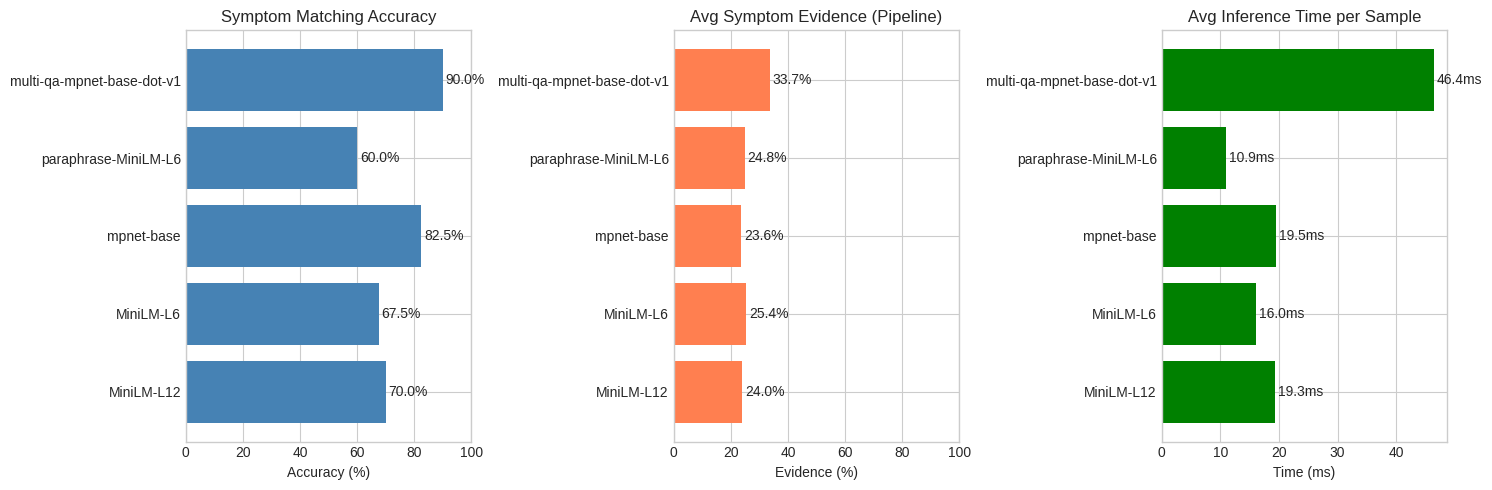

In [42]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = df_summary['Model'].str.replace('all-', '').str.replace('-v2', '')

# Symptom Matching
axes[0].barh(models, df_summary['Symptom Match %'], color='steelblue')
axes[0].set_xlabel('Accuracy (%)')
axes[0].set_title('Symptom Matching Accuracy')
axes[0].set_xlim([0, 100])
for i, v in enumerate(df_summary['Symptom Match %']):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center')

# Avg Symptom Evidence (Pipeline)
axes[1].barh(models, df_summary['Avg Symptom Evidence %'], color='coral')
axes[1].set_xlabel('Evidence (%)')
axes[1].set_title('Avg Symptom Evidence (Pipeline)')
axes[1].set_xlim([0, 100])
for i, v in enumerate(df_summary['Avg Symptom Evidence %']):
    axes[1].text(v + 1, i, f'{v:.1f}%', va='center')

# Inference Time
axes[2].barh(models, df_summary['Time (ms)'], color='green')
axes[2].set_xlabel('Time (ms)')
axes[2].set_title('Avg Inference Time per Sample')
for i, v in enumerate(df_summary['Time (ms)']):
    axes[2].text(v + 0.5, i, f'{v:.1f}ms', va='center')

plt.tight_layout()
plt.savefig(project_root / 'notebooks' / 'figures' / 'semantic_model_comparison_results.png', dpi=150)
plt.show()


## 3.6 Per-Symptom Breakdown

In [43]:
# Show per-symptom performance for each model
for result in comparison_results:
    if 'Per-Symptom' in result:
        print(f"\n{result['Model']}:")
        for symptom, acc in sorted(result['Per-Symptom'].items(), key=lambda x: x[1], reverse=True):
            filled = int(round(acc * 10))
            bar = '█' * filled + '░' * (10 - filled)
            print(f"  {symptom:25s} {bar} {acc*100:5.1f}%")



all-MiniLM-L12-v2:
  chest pain                ██████████ 100.0%
  shortness of breath       ██████████ 100.0%
  cough                     ██████████ 100.0%
  headache                  ████████░░  75.0%
  nausea                    ████████░░  75.0%
  vomiting                  ████████░░  75.0%
  fever                     █████░░░░░  50.0%
  dizziness                 █████░░░░░  50.0%
  abdominal pain            █████░░░░░  50.0%
  fatigue                   ██░░░░░░░░  25.0%

all-MiniLM-L6-v2:
  headache                  ██████████ 100.0%
  cough                     ██████████ 100.0%
  abdominal pain            ██████████ 100.0%
  chest pain                ████████░░  75.0%
  fatigue                   ████████░░  75.0%
  vomiting                  ████████░░  75.0%
  fever                     █████░░░░░  50.0%
  nausea                    █████░░░░░  50.0%
  dizziness                 █████░░░░░  50.0%
  shortness of breath       ░░░░░░░░░░   0.0%

all-mpnet-base-v2:
  nausea             

## 3.7 Recommendations

In [44]:
# Find best models
best_accuracy = df_summary.loc[df_summary['Symptom Match %'].idxmax()]
best_speed = df_summary.loc[df_summary['Time (ms)'].idxmin()]
best_evidence = df_summary.loc[df_summary['Avg Symptom Evidence %'].idxmax()]

print("RECOMMENDATIONS")
print("=" * 60)
print(f"\n📊 Best Symptom Matching: {best_accuracy['Model']} ({best_accuracy['Symptom Match %']:.1f}%)")
print(f"🎯 Best Avg Symptom Evidence: {best_evidence['Model']} ({best_evidence['Avg Symptom Evidence %']:.1f}%)")
print(f"⚡ Fastest Inference:     {best_speed['Model']} ({best_speed['Time (ms)']:.1f}ms)")

# Calculate overall score (weighted)
df_summary['Overall Score'] = (
    df_summary['Symptom Match %'] * 0.4 +
    df_summary['Avg Symptom Evidence %'] * 0.4 +
    (100 - df_summary['Time (ms)'].clip(0, 100)) * 0.2
)

best_overall = df_summary.loc[df_summary['Overall Score'].idxmax()]

print(f"\n🏆 RECOMMENDED MODEL: {best_overall['Model']}")
print(f"   Overall Score: {best_overall['Overall Score']:.1f}")

RECOMMENDATIONS

📊 Best Symptom Matching: multi-qa-mpnet-base-dot-v1 (90.0%)
🎯 Best Avg Symptom Evidence: multi-qa-mpnet-base-dot-v1 (33.7%)
⚡ Fastest Inference:     paraphrase-MiniLM-L6-v2 (10.9ms)

🏆 RECOMMENDED MODEL: multi-qa-mpnet-base-dot-v1
   Overall Score: 60.2


In [46]:
# Save results
results_path = data_root / 'models' / 'checkpoints' / 'semantic_model_comparison_results.json'

# Convert to serializable format
export_results = []
for r in comparison_results:
    export_r = {}
    for k, v in r.items():
        if k == 'Per-Symptom':
            export_r[k] = {symptom: float(acc) for symptom, acc in v.items()}
        elif isinstance(v, (np.float32, np.float64)):
            export_r[k] = float(v)
        else:
            export_r[k] = v
    export_results.append(export_r)

with open(results_path, 'w') as f:
    json.dump(export_results, f, indent=2)

print(f"\nResults saved to: {results_path}")


Results saved to: /content/drive/MyDrive/Multi_Modal_Data/models/checkpoints/semantic_model_comparison_results.json


---
# Summary

**Training:**
- Vocabulary: `data/symptom_vocabulary.json` (480 symptoms)
- Embeddings: `data/embeddings/semantic_symptom_embeddings.npy`
- Model: multi-qa-mpnet-base-dot-v1 (768-dim embeddings)

**Recommended Settings:**
- `similarity_threshold`: 0.45-0.50
- `top_k`: 15-20
- `use_sentence_level`: True (default)

**Known Limitations:**
- Negation not handled ("I don't have fever" may detect fever)

In [47]:
print("✅ Semantic Symptom Encoder ready!")
print(f"\nConfiguration:")
print(f"  Model: {encoder.model_name}")
print(f"  Symptoms: {len(encoder.symptoms)}")

✅ Semantic Symptom Encoder ready!

Configuration:
  Model: all-MiniLM-L12-v2
  Symptoms: 480
